In [1]:
import torch
import torch.nn as nn
from torchvision.models import resnet18, ResNet18_Weights
import torch.nn.functional as F 
import matplotlib.pyplot as plt

In [2]:
weights= ResNet18_Weights.DEFAULT
preprocess= weights.transforms()

In [3]:
resnet= resnet18(weights=weights)

In [4]:
resnet.eval()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [5]:
resnet=torch.nn.Sequential(*list(resnet.children())[:-2])
resnet.eval()

Sequential(
  (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU(inplace=True)
  (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (4): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Con

In [6]:
class SegmentationHead(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(SegmentationHead, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, 512, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(512, 256, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(256, out_channels, kernel_size=3, padding=1)
        self.upsample1 = nn.Upsample(scale_factor=9, mode='bilinear', align_corners=True)
        self.upsample2= nn.Upsample(scale_factor=10, mode='bilinear', align_corners=True)


    def forward(self, x):
        print(x.shape)
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.upsample1(x)
        x = self.upsample2(x)
        return x

In [7]:
class SegmentationModel(nn.Module):
    def __init__(self, num_classes):
        super(SegmentationModel, self).__init__()
        self.weights= ResNet18_Weights.DEFAULT
        resnet = resnet18(weights=self.weights)
        # Modify the first convolutional layer to accept 1 input channel
        # resnet.conv1 = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)
        # with torch.no_grad():
        #     resnet.conv1.weight[:, 0] = self.weights.get_state_dict()['conv1.weight'][:, :3].mean(dim=1)
        self.backbone= torch.nn.Sequential(*list(resnet.children())[:-2])
        self.segmentation_head = SegmentationHead(in_channels=512, out_channels=num_classes)

    def forward(self, x):
        x= self.weights.transforms()(x)
        print(x.shape)
        # Pass input through the backbone
        with torch.no_grad():
            features = self.backbone(x)
        print(features.shape)
        # Pass features through the segmentation head
        output = self.segmentation_head(features)
        print(output.shape)
        output = F.softmax(output, dim=1)
        return output

In [8]:
# Number of output classes (e.g., for binary segmentation, num_classes=1)
num_classes = 7

# Initialize the segmentation model
model = SegmentationModel(num_classes=num_classes)

# Move the model to the appropriate device (CPU or GPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

In [9]:
input=torch.ones((1,3,630,630))

In [10]:
with torch.inference_mode():
    output=model(input.to(device))

torch.Size([1, 3, 224, 224])
torch.Size([1, 512, 7, 7])
torch.Size([1, 512, 7, 7])
torch.Size([1, 7, 630, 630])


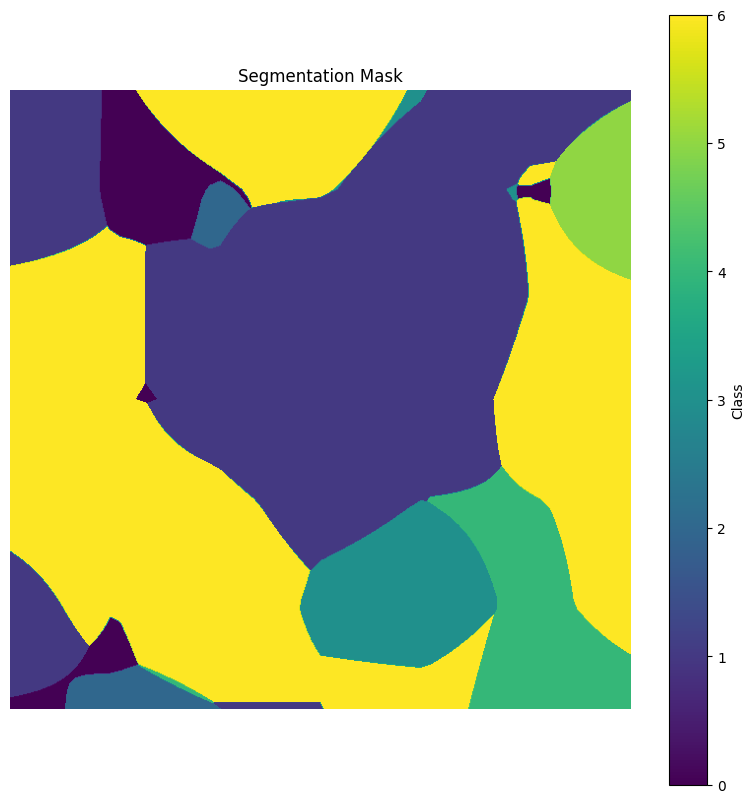

In [12]:
output = output.squeeze(0)  # Shape: (7, 630, 630)

# Get the predicted class by taking the argmax along the class dimension
predicted_classes = torch.argmax(output, dim=0)  # Shape: (630, 630)

# Step 3: Plot the segmentation mask
plt.figure(figsize=(10, 10))
plt.imshow(predicted_classes.cpu(), cmap='viridis')  # Use a colormap for better visualization
plt.colorbar(label='Class')
plt.title('Segmentation Mask')
plt.axis('off')  # Hide axes
plt.show()